# Cell Growth Optimization
This lab will demonstrate how users can execute API calls to the Tetra Scientific Data Cloud from a Google CoLab Notebook.

# Configure Python Imports

In order to run our Jupyter Notebook,  we will need the following libraries:
- requests: This library is used to make HTTP Requests to the TDP API
- json:  Allows us to manipulate files as JSON Objects
- pandas:  This is a very useful library for storing data in tabular structures
- numpy:  Open Source Framework for mathematical computation
- matplotlib: Library for creating visualizations of your data
- pydash: Considered the “kitchen sink” of python utilities
- ipywidgets: Allows us to create drop-down lists
- seaborn: Python data visualization library based on matplotlib
- datetime: self-explanatory

In [ ]:
# @title
# Install dependencies
!pip install pydash requests numpy pandas matplotlib seaborn ipywidgets

# Import modules
import requests, json, datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import pydash

import ipywidgets as widgets
from IPython.display import display
import getpass

# Functions
hits_to_df:  This function transforms the Tetra API results to a pandas dataframe which is easy to utilize in visualizations.  It also allows for renaming the Columns for all of the attributes/fields of the dataframe.

parse_run_name:  This function parses the run name to extract only the Cell Group name

get_hour_from_time: parses a data object and returns the hours and minutes as a string

clean_df_and_get_exp_day:  This function takes the Vi-CELL pandas dataframe data and adds the amount of days from the first run.  This is used in the line chart.

BLANK` = '---':  This is a variable representing a blank row in the drop downs

unique_sorted_values_plus_ALL:  This function sorts the drop down and ensures that the blank row is the first option in the list

cell_group_dropdown_eventhandler:  Event handler when the cell group drop-down changes

day_dropdown_eventhandler:  Event handler when the specific day of a Cell Group run is selected.

In [ ]:
# Import custom functions
def hits_to_df(hits, mapping):
    out_df_cols = [d["column_name"] for d in mapping]
    out_df = pd.DataFrame(columns=out_df_cols)
    all_rows = []
    for hit in hits:
        #print(hit)
        ids = hit['_source']
        row = {d["column_name"]: pydash.get(ids, d["hit_key"]) for d in mapping}
        all_rows.append(row)
    out_df = pd.DataFrame.from_records(all_rows)
    return out_df

# Always take the first element after splitting the string
def parse_run_name(run_name):
    if '-' in run_name:
        return run_name.split('-')[0].upper()
    elif ' ' in run_name:
        return run_name.split(' ')[0].upper()
    elif '_' in run_name:
        return run_name.split('_')[0].upper()
    else:
        raise ValueError('We messed up :/')

def get_hour_from_time(run_time):
  return run_time.strftime('%H:%M')
  #return "{:d}:{:02d}".format(run_time., run_time.minute)


def clean_df_and_get_exp_day(df):

    # Add group name
    df = df.assign(
        group=df['run_name'].apply(parse_run_name))

    # Change run time to datetime object
    df.run_time = pd.to_datetime(df.run_time)



    # Get min day for each group
    first_run = df[['run_time', 'group']].groupby('group').min()
    first_run_d = {row[0]: row[1] for row in first_run.itertuples()}

    # Calculate experiment day by comparing with the first run in that group
    start_dates = df.group.map(first_run_d)
    time_delta_seconds = (df.run_time-start_dates).dt.total_seconds()
    time_delta_days = pd.Series(round(time_delta_seconds/(60*60*24)), dtype='int')

    # Assign experiment day to df
    df = df.assign(day=time_delta_days)

    # Add hour in day to df
    df = df.assign(time=df['run_time'].apply(get_hour_from_time))

    return df

BLANK = '---'

def unique_sorted_values_plus_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, BLANK)
    return unique

def cell_group_dropdown_eventhandler(change):
    #print(change)
    #hide(day_dropdown)
    day_dropdown.options = [BLANK]
    day_dropdown.disabled = False
    if (change.new == BLANK):
      day_dropdown.disabled = True
    else:
      day_dropdown.options = unique_sorted_values_plus_ALL(tetra_data_df[tetra_data_df.group == change.new].day)

def day_dropdown_eventhandler(change):
  #print(cell_group_dropdown.value)
  if (change.new != BLANK):
    tmp_df = tetra_data_df[tetra_data_df.group == cell_group_dropdown.value]
    tmp_df = tmp_df[tmp_df.day == change.new]
    # Sort the dataframe by group and run start
    tmp_df = tmp_df.sort_values(by=['time'])
    #display(tmp_df)
    show_cell_density_plot(tmp_df, 'time', 'Day ' + str(change.new) + ' Culture Time')

# Configure Connection Variables

Create and store information on how to connect to the TDP API

In [ ]:
searchEQL_url = "https://api.tetrascience-uat.com/v1/datalake/searchEql"
org_slug = "training-george-temp"

# set the value for your user within the platform
my_user = 'george-vandendriessche'
#labels.name:"user" labels.value:"george-vandendriessche"

searchEQL_url

'https://api.tetrascience-uat.com/v1/datalake/searchEql'

We will embed our API credentials using GetPass.

GetPass is a password authentication library that prompts a user for a token, variable, or password that is stored for the kernel activity but is not hard-coded into the workbook.

In [ ]:
user_token = getpass.getpass()
headers = {"x-org-slug": org_slug, "ts-auth-token": user_token}

··········


# Set Query to Search for All Vi-CELL Runs

The TDP API uses ElasticSearch for indexing the Vi-CELL Content.  This powerful tool allows advanced searching against the data to find the appropriate information based upon your use case(s).

In this scenario, we are creating a query to find all of the Vi-CELL RAW/Source content with the “user” metadata attribute with your name as the value.  We are first finding all of the RAW files so that we can create a drop-down list of all the unique Runs that have been ingested.

Notice the filter terms used in the query to find the appropriate content.  The “my_user” filter will match what you used in the earlier code window to set that variable.

In [ ]:
payload = {
    "size": 1000,
    #non-nested query by file category and source type
    "query": {
        "bool": {
            "must": [
                {"term": {"category": "RAW"}},
                {"term": {"source.type": "beckman-coulter-cell-counter"}},
                {
    #nested query using user labels
                    "nested": {
                        "path": "labels",
                        "query": {
                            "bool": {
                                "must": [
                                    {"term": {"labels.name": "user"}},
                                    {"term": {"labels.value": my_user}}
                                ]
                            }
                        }
                    }
                }
            ]
        }
    }
}

# Run Search Request and Display Results

We will now use the requests library to make a request to the TDP API.  We have previously configured the connection variables as well as the query we are executing.

Our final line just has the variable "result" in it which tells the Notebook to print the value of the variable.

In [ ]:
request = requests.post(searchEQL_url, json=payload, headers=headers)

result = request.json()
print("Here are the keys returned from our JSON request:", result.keys())

print("This is a snapshot of the returned object")
json.dumps(result['hits'], indent = 2)
#list(result.items())[:3]

Here are the keys returned from our JSON request: dict_keys(['took', 'timed_out', '_shards', 'hits'])
This is a snapshot of the returned object


'{\n  "total": 9,\n  "max_score": 2.5837793,\n  "hits": [\n    {\n      "_index": "training-george-temp_raw",\n      "_type": "entity",\n      "_id": "rCl2dRKPtwOh5..U0idWAza5qk8lTUUL",\n      "_score": 2.5837793,\n      "_source": {\n        "traceId": "38845706-7ce6-4fea-9370-b0620b8f6dfd",\n        "orgSlug": "training-george-temp",\n        "indexedAt": "2023-11-29T16:21:56.816Z",\n        "filePath": "/EC2AMAZ-7LI7OP8/c/users/administrator/documents/vi-cell/07dec-igg_v46.zip",\n        "source": {\n          "agent": "TetraScience.Agent.file-log v4.3.2",\n          "name": "File Log Agent - George-VanDenDriessche",\n          "id": "79f353bc-72dc-454f-9064-7be55c4ce5ff",\n          "type": "beckman-coulter-cell-counter"\n        },\n        "labels": [\n          {\n            "name": "user",\n            "value": "george-vandendriessche"\n          },\n          {\n            "name": "run_name",\n            "value": "igg_v46"\n          },\n          {\n            "name": "ts

## Select the Run to Analyze

Now let’s take the API results, find all of the unique runs and put them inside a drop-down list for the user to select the run they wish to analyze.

It is possible that a single Vi-CELL output file contains many individual sample runs over multiple days. It is also possible that a single Vi-CELL output file only contains one sample run.

The next code block will create the drop-down and show all of the unique runs regardless of whether one or many sample runs are in the Vi-CELL output files.

In [ ]:
#labels.name:"run_name" labels.value:"igg_v46"
runs_mapping = [
    {"hit_key": "labels.1.value", "column_name": "run_name"}
]

#create runs list
##each item in list is a dict (the IDS file!)
runs = result['hits']['hits']

# Convert the API JSON results to a Dataframe based upon the column mapping above (It will have one column with the run_name metadata values)
runs_df = hits_to_df(runs, runs_mapping)

# Create the Drop-Down options list and Add "---" as the first option
dropdown_options = unique_sorted_values_plus_ALL(runs_df.run_name)

runs_dropdown = widgets.Dropdown(options = dropdown_options, description="Select Run to Analyze: ")
#runs_dropdown.observe(runs_dropdown_eventhandler, names='value')

display(runs_dropdown)

Dropdown(description='Select Run to Analyze: ', options=('---', 'igg_v46'), value='---')

## Retrieve the Harmonized Tetra Data Associated with the Selected Run

Now we will call the TDP REST API again to retrieve the harmonized Tetra Data (IDS Data) based upon the selected run above.  We will again create an Elasticsearch query to find the content.  Notice how the term "category" is set to IDS, the term "idsType" is set to cell-counter, the run_name is set to the current drop-down list value, and the term "metadata.user" is set to your user you defined earlier for the "my_user" variable.

The following code cell will set the query, execute it, and print the results.

In [ ]:
#new query using nested search on labels
payload = {
    "size": 1000,
    #non-nested search to filter by file category and instrument type
    "query": {
        "bool": {
            "must": [
                {"term": {"category": "IDS"}},
                {"term": {"source.type": "beckman-coulter-cell-counter"}},
                #nested search 1 by user
                 {
                    "nested": {
                        "path": "labels",
                        "query": {
                            "bool": {
                                "must": [
                                    {"term": {"labels.name": "user"}},
                                    {"term": {"labels.value": my_user}}
                                ]
                            }
                        }
                    }
                }
                   #nested search 2 by run name
                #     {
                #     "nested": {
                #         "path": "labels",
                #         "query": {
                #             "bool": {
                #                 "must": [
                #                     {"term": {"labels.name": "run_name"}},
                #                     {"term": {"labels.value": runs_dropdown.value}}
                #                 ]
                #             }
                #         }
                #     }
                # }
            ]
        }
    }
}

request = requests.post(searchEQL_url, json=payload, headers=headers)

tetra_data = request.json()

tetra_data

{'took': 10,
 'timed_out': False,
 '_shards': {'total': 9, 'successful': 9, 'skipped': 0, 'failed': 0},
 'hits': {'total': 9,
  'max_score': 2.423882,
  'hits': [{'_index': 'training-george-temp_ids_cell-counter_v8.0.0',
    '_type': 'entity',
    '_id': 'w4CxogCtYkbyWyiWOW7yKOaItRMmTf3v',
    '_score': 2.423882,
    '_source': {'traceId': '0a9a2aef-97d4-4774-aac5-1e84d152f5ec',
     'orgSlug': 'training-george-temp',
     'indexedAt': '2023-11-29T16:24:35.550Z',
     'rawFileId': '0a9a2aef-97d4-4774-aac5-1e84d152f5ec',
     'data': {'@idsConventionVersion': 'v1.0.0',
      'related_files': [{'pointer': {'bucket': 'ts-dip-uat-datalake',
         'fileKey': 'training-george-temp/79f353bc-72dc-454f-9064-7be55c4ce5ff/PROCESSED/EC2AMAZ-7LI7OP8/c/users/administrator/documents/vi-cell/05dec-igg_v46.zip/IgG 05dec18 v46_1.tif',
         'type': 's3file',
         'version': 'OnKvoBqjrdIxSj6Na3lrT46nFlYosfpy',
         'fileId': 'a97be9bd-f786-4bd4-9829-00cfebd588c2'},
        'name': 'IgG 05de

In [ ]:
num_hits = tetra_data['hits']['total']

print(f'Number of ViCell Cell Counter Run Tetra Data Results: {num_hits}')

Number of ViCell Cell Counter Run Tetra Data Results: 9


## Create a Pandas DataFrame out of the Results and Print the Table

Now let's print the results as a table by converting them to a Pandas DataFrame.  We are also accessing and renaming the columns in the DataFrame to make them more easily readable as a table.  This is done using the mapping variable we will create.

In [ ]:
mapping = [
    {"hit_key": "labels.1.value", "column_name": "run_name"},
    {"hit_key": "data.runs[0].time.stop", "column_name": "run_time"},
    {"hit_key": "data.results[0].cell.density.viable.value", "column_name": "viable_density"}
]
# isolate the vi-cell tetra data files from the API response
tetra_data_hits = tetra_data['hits']['hits']
#  now convert the API result to a Pandas DataFrame using the "mapping" var above
tetra_data_df = hits_to_df(tetra_data_hits, mapping)

# now call one of the functions we pasted earlier to add a field to this DataFrame.  It will add the amount of days for each run from the beginning of the first run in the result list
tetra_data_df = clean_df_and_get_exp_day(tetra_data_df)

# now print the DataFrame
tetra_data_df

,run_name,run_time,viable_density,group,day,time
0,igg_v46,2018-12-05 09:24:02+00:00,9.0301,IGG,0,09:24
1,igg_v46,2018-12-08 09:09:21+00:00,28.4377,IGG,3,09:09
2,igg_v46,2018-12-12 08:19:05+00:00,28.8990,IGG,7,08:19
3,igg_v46,2018-12-07 08:45:11+00:00,21.7810,IGG,2,08:45
4,igg_v46,2018-12-06 07:25:53+00:00,13.1540,IGG,1,07:25
5,igg_v46,2018-12-10 08:13:39+00:00,35.7067,IGG,5,08:13
6,igg_v46,2018-12-14 09:05:23+00:00,26.6916,IGG,9,09:05
7,igg_v46,2018-12-11 08:19:08+00:00,30.4210,IGG,6,08:19
8,igg_v46,2018-12-13 09:59:47+00:00,28.1963,IGG,8,09:59


# Plot the Data using Python Viz Libraries

Now we will use open source visualization libraries to plot the data in a Line Graph.

The following code sets some UI styles and uses the Seaborn libraries to create the graph.

There is an additional function called add_missing_days that looks at all of the result data we have for the selected run and finds any days missing sample results.  It will then add the missing day with no values in it causing the graph to show the missing data.  This can help the analyst understand if there is a potential issue with the processes in the lab causing the missing data.

<ipython-input-25-0b6b1cd588ac>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_days_data['viable_density'].fillna(substitute_na, inplace = True)


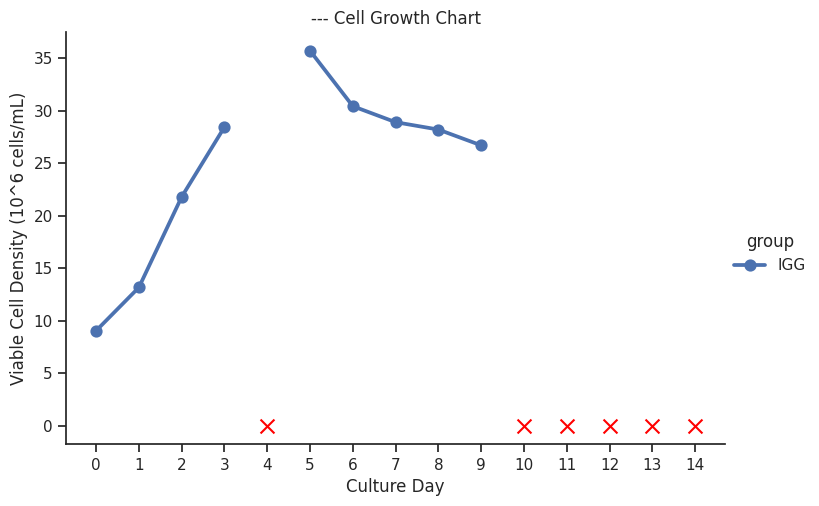

In [ ]:
# Set the plotting style
sns.set(style='ticks', font='sans', font_scale=1.0)

# sometimes the collected results are missing days.  This may be relevant for analysis.
# Add those days so they show up in the chart with missing data
def add_missing_days(df):
    df = df.sort_values(by=['day', 'group'])
    newdf = pd.DataFrame()

    for group, group_df in df.groupby('group'):
        min_day = group_df['day'].min()
        #max_day = group_df['day'].max()
        max_day = 14

        missing_days = set(range(min_day, max_day + 1)) - set(group_df['day'])
        missing_rows = [{'day': day, 'group': group} for day in missing_days]

        newdf = pd.concat([newdf, group_df, pd.DataFrame(missing_rows)])

    newdf = newdf.sort_values(by=['group', 'day']).reset_index(drop=True)
    return newdf

def show_cell_density_plot(dFrame, xAxis, xLabel):
    # Add missing days
    dFrame = add_missing_days(dFrame)

    # Make the plot with Seaborn
    sns.catplot(data=dFrame, x=xAxis, hue='group', y='viable_density', kind='point', aspect=1.5)

    # Identify and plot missing days with red 'x' markers
    missing_days_data = dFrame[dFrame['viable_density'].isnull()]
    substitute_na = 0
    missing_days_data['viable_density'].fillna(substitute_na, inplace = True)
    plt.scatter(missing_days_data[xAxis], missing_days_data['viable_density'], color='red', marker='x', s = 100, label='Missing Days')

    # Additional plot formatting
    plt.title(runs_dropdown.value + ' Cell Growth Chart')
    plt.ylabel('Viable Cell Density (10^6 cells/mL)')
    plt.xlabel(xLabel)

    # Show the plot
    plt.show()

show_cell_density_plot(add_missing_days(tetra_data_df), 'day', 'Culture Day')

## Display a Set of Drop-Downs to select a specific Cell Group and Day

Operators perform at-line sampling to perform process monitoring to ensure proper cellular growth and to quickly identify instrument or sensor failures, and even potentially contamination risks that would halt a study.

We will add some drop-down lists to allow the user to select the appropriate Cell Group and the Day to create an at-line cell growth chart.

In [ ]:
### Prepare the Chart by Day UI Widgets

#Now we will initialise the cell group dropdown:
cell_group_dropdown = widgets.Dropdown(options = unique_sorted_values_plus_ALL(tetra_data_df.group), description="Cell Group: ")

# register this dropdown with an Event Handler to fill the Day dropdown.  The event handler function was pasted in earlier near the beginning of this jupyter notebook:
cell_group_dropdown.observe(cell_group_dropdown_eventhandler, names='value')

#Now we will initialize the day dropdown and it's even handler which will display the graph for the daily values:
day_dropdown = widgets.Dropdown(description="Culture Day: ", disabled=True)
day_dropdown.observe(day_dropdown_eventhandler, names='value')

display(cell_group_dropdown)
display(day_dropdown)

Dropdown(description='Cell Group: ', options=('---', 'IGG'), value='---')

Dropdown(description='Culture Day: ', disabled=True, options=(), value=None)

Unfortunately, our scrubbed sample data set is rather limited, and therefore there is not more than one data point per Culture Day.    Therefore I’m providing a set of image examples of what this would look like with many Cell Groups and many Sample points per day (Sensitive data has been masked):

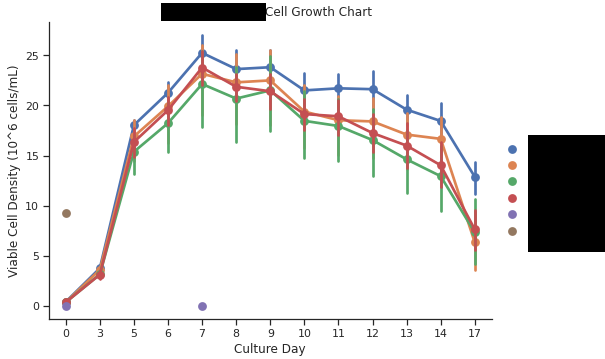


And then the Culture Day chart for the 7th day for the Green Cell Group Above:

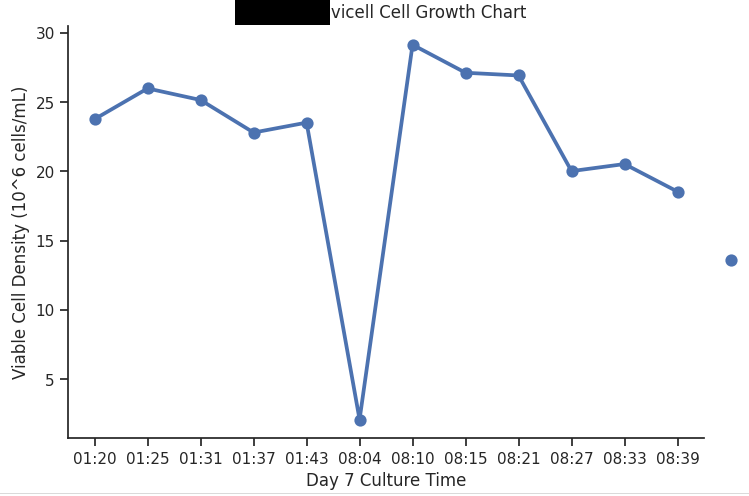

In the above example it would appear that either an instrument failure or a sampling error occurred at the 8:04 AM sampling. This easily determined because the next sampling shows the Viable Cell Density (VCD) measurement returning to normal levels.